# ASSIGNMENT
- Use the Caterpillar dataset (or _any_ dataset of your choice). **Make these 3 types of visualizations** for model interpretation:
  - Feature Importances
  - Permutation Importances
  - Partial Dependence Plot
- **Share at least 1 of your visualizations on Slack.**
- Commit your notebook to your fork of the GitHub repo.


## Stretch Goals
- Improve your scores on Kaggle! Look at [Kaggle Kernels](https://www.kaggle.com/c/caterpillar-tube-pricing/kernels) for ideas. **Share your best features and techniques on Slack.**
- Try the [Skater library](https://oracle.github.io/Skater/index.html), which is an another option to get permutation importances and partial dependence plots.
- Can you figure out partial dependence plots with categorical features?
- Check out the links at the top of this notebook to learn more about how to interpret "black box" machine learning models.

In [1]:
import pandas as pd
import numpy as np
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
import category_encoders as ce
from sklearn.metrics import mean_squared_error
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:.2f}'.format)

In [6]:
!curl https://github.com/WillHK/DS-Unit-2-Regression-2/blob/master/module1-log-linear-regression/data.zip > data.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 65662    0 65662    0     0  77706      0 --:--:-- --:--:-- --:--:-- 77614


In [9]:
!kaggle competitions download -c caterpillar-tube-pricing

  0%|                                                | 0.00/225k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 225k/225k [00:00<00:00, 11.9MB/s]
  0%|                                                | 0.00/794k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 794k/794k [00:00<00:00, 14.0MB/s]


In [10]:
!unzip data.zip

Archive:  data.zip
   creating: competition_data/
  inflating: competition_data/bill_of_materials.csv  
  inflating: competition_data/comp_adaptor.csv  
  inflating: competition_data/comp_boss.csv  
  inflating: competition_data/comp_elbow.csv  
  inflating: competition_data/comp_float.csv  
  inflating: competition_data/comp_hfl.csv  
  inflating: competition_data/comp_nut.csv  
  inflating: competition_data/comp_other.csv  
  inflating: competition_data/comp_sleeve.csv  
  inflating: competition_data/comp_straight.csv  
  inflating: competition_data/comp_tee.csv  
  inflating: competition_data/comp_threaded.csv  
  inflating: competition_data/components.csv  
  inflating: competition_data/specs.csv  
  inflating: competition_data/test_set.csv  
  inflating: competition_data/train_set.csv  
  inflating: competition_data/tube.csv  
  inflating: competition_data/tube_end_form.csv  
  inflating: competition_data/type_component.csv  
  inflating: competition_data/type_connection.csv  
  i

In [11]:
!rm data.zip

In [12]:
trainval = pd.read_csv('competition_data/train_set.csv')
test = pd.read_csv('competition_data/test_set.csv')

In [13]:
# Create dict of all dataframes
dfs = {}
for path in glob('competition_data/*.csv'):
    folder, file = path.split('/')
    name, extension = file.split('.')
    if name != 'train_set' and name != 'test_set':
        dfs[name] = pd.read_csv(path)

In [15]:
materials = dfs['bill_of_materials'].copy()
materials.head()

,tube_assembly_id,component_id_1,quantity_1,component_id_2,quantity_2,component_id_3,quantity_3,component_id_4,quantity_4,component_id_5,quantity_5,component_id_6,quantity_6,component_id_7,quantity_7,component_id_8,quantity_8
0,TA-00001,C-1622,2.00,C-1629,2.00,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan
1,TA-00002,C-1312,2.00,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan
2,TA-00003,C-1312,2.00,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan
3,TA-00004,C-1312,2.00,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan
4,TA-00005,C-1624,1.00,C-1631,1.00,C-1641,1.00,NaN,nan,NaN,nan,NaN,nan,NaN,nan,NaN,nan


In [16]:
components = dfs['components']
components.describe()

,component_id,name,component_type_id
count,2048,2047,2048
unique,2048,297,29
top,C-1200,FLANGE,OTHER
freq,1,350,1006


In [17]:
assembly_components = materials.melt(id_vars='tube_assembly_id',
                                     value_vars=[f'component_id_{n}' for n in range(1,9)])

assembly_components = (assembly_components
                       .sort_values(by='tube_assembly_id')
                       .dropna()
                       .rename(columns={'value': 'component_id'}))

assembly_components.head()

,tube_assembly_id,variable,component_id
0,TA-00001,component_id_1,C-1622
21198,TA-00001,component_id_2,C-1629
1,TA-00002,component_id_1,C-1312
2,TA-00003,component_id_1,C-1312
3,TA-00004,component_id_1,C-1312


In [18]:
assembly_component_types = assembly_components.merge(components, how='left')
assembly_component_types.head()

,tube_assembly_id,variable,component_id,name,component_type_id
0,TA-00001,component_id_1,C-1622,NUT-SWIVEL,CP-025
1,TA-00001,component_id_2,C-1629,SLEEVE-ORFS,CP-024
2,TA-00002,component_id_1,C-1312,NUT-FLARED,CP-028
3,TA-00003,component_id_1,C-1312,NUT-FLARED,CP-028
4,TA-00004,component_id_1,C-1312,NUT-FLARED,CP-028


In [19]:
table = pd.crosstab(assembly_component_types['tube_assembly_id'],
                    assembly_component_types['component_type_id'])
table = table.reset_index()
table.columns.name = ''
print(table.shape)
table.head()

(19149, 30)


,tube_assembly_id,CP-001,CP-002,CP-003,CP-004,CP-005,CP-006,CP-007,CP-008,CP-009,CP-010,CP-011,CP-012,CP-014,CP-015,CP-016,CP-017,CP-018,CP-019,CP-020,CP-021,CP-022,CP-023,CP-024,CP-025,CP-026,CP-027,CP-028,CP-029,OTHER
0,TA-00001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
1,TA-00002,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,TA-00003,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,TA-00004,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,TA-00005,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0


In [21]:
def search_column(name):
    for df in dfs:
        if name in dfs[df].columns:
            print(df, dfs[df].shape)
            print(dfs[df].columns.tolist(), '\n')
            
search_column('weight')

comp_threaded (194, 32)
['component_id', 'component_type_id', 'adaptor_angle', 'overall_length', 'hex_size', 'end_form_id_1', 'connection_type_id_1', 'length_1', 'thread_size_1', 'thread_pitch_1', 'nominal_size_1', 'end_form_id_2', 'connection_type_id_2', 'length_2', 'thread_size_2', 'thread_pitch_2', 'nominal_size_2', 'end_form_id_3', 'connection_type_id_3', 'length_3', 'thread_size_3', 'thread_pitch_3', 'nominal_size_3', 'end_form_id_4', 'connection_type_id_4', 'length_4', 'thread_size_4', 'thread_pitch_4', 'nominal_size_4', 'unique_feature', 'orientation', 'weight'] 

comp_adaptor (25, 20)
['component_id', 'component_type_id', 'adaptor_angle', 'overall_length', 'end_form_id_1', 'connection_type_id_1', 'length_1', 'thread_size_1', 'thread_pitch_1', 'nominal_size_1', 'end_form_id_2', 'connection_type_id_2', 'length_2', 'thread_size_2', 'thread_pitch_2', 'nominal_size_2', 'hex_size', 'unique_feature', 'orientation', 'weight'] 

comp_straight (361, 12)
['component_id', 'component_type_i

In [22]:
comp_threaded = dfs['comp_threaded']
comp_threaded['orientation'].value_counts()

No     121
Yes     73
Name: orientation, dtype: int64

In [23]:
comp_threaded['unique_feature'].value_counts()

No     161
Yes     33
Name: unique_feature, dtype: int64

In [24]:
comp = pd.concat((pd.read_csv(path) for path in glob('competition_data/comp_*.csv')), sort=False)
columns = ['component_id', 'component_type_id', 'orientation', 'unique_feature', 'weight']
comp = comp[columns]
comp['orientation'] = (comp['orientation'] == 'Yes').astype(int)
comp['unique_feature'] = (comp['unique_feature'] == 'Yes').astype(int)
comp['weight'] == comp['weight'].fillna(comp['weight'].median())

0        True
1        True
2        True
3        True
4        True
5        True
6        True
7        True
8        True
9        True
10       True
11       True
12       True
13       True
14       True
15       True
16       True
17       True
18       True
19       True
20       True
21       True
22       True
23       True
24       True
25       True
26       True
27       True
28       True
29       True
30       True
31       True
32       True
33       True
34       True
35       True
36       True
37       True
38       True
39       True
40       True
41       True
42       True
43       True
44       True
45       True
46       True
47       True
48       True
49       True
50       True
51       True
52       True
53       True
54       True
55       True
56       True
57       True
58       True
59       True
60       True
61       True
62       True
63       True
64       True
65       True
66       True
67       True
68       True
69       True
70       True
71    

In [25]:
materials['components_total'] = sum(materials[f'quantity_{n}'] for n in range(1,9))
materials['components_distinct'] = sum(materials[f'component_id_{n}'].notnull().astype(int) for n in range(1,9))
materials['orientation'] = 0
materials['unique_feature'] = 0
materials['weight'] = 0

for n in range(1,9):
    materials = materials.merge(comp, left_on=f'component_id_{n}', right_on='component_id',
                                how='left', suffixes=('', f'_{n}'))
    
for col in materials:
    if 'orientation' in col or 'unique_feature' in col or 'weight' in col:
        materials[col] = materials[col].fillna(0)
        
materials['orientation'] = sum(materials[f'orientation_{n}'] for n in range(1,9))
materials['unique_feature'] = sum(materials[f'unique_feature_{n}'] for n in range(1,9))
materials['weight'] = sum(materials[f'weight_{n}'] for n in range(1,9))

features = ['tube_assembly_id', 'orientation', 'unique_feature', 'weight',
            'components_total', 'components_distinct', 'component_id_1']
materials = materials[features]
materials.head()
                                         

,tube_assembly_id,orientation,unique_feature,weight,components_total,components_distinct,component_id_1
0,TA-00001,0.00,1.00,0.05,nan,2,C-1622
1,TA-00002,0.00,0.00,0.01,nan,1,C-1312
2,TA-00003,0.00,0.00,0.01,nan,1,C-1312
3,TA-00004,0.00,0.00,0.01,nan,1,C-1312
4,TA-00005,0.00,1.00,0.21,nan,3,C-1624


In [26]:
tube = dfs['tube'].copy()

In [28]:
trainval_tube_assemblies = trainval['tube_assembly_id'].unique()
train_tube_assemblies, val_tube_assemblies = train_test_split(
trainval_tube_assemblies, random_state=42)

train = trainval[trainval.tube_assembly_id.isin(train_tube_assemblies)]
val = trainval[trainval.tube_assembly_id.isin(val_tube_assemblies)]


In [29]:
def wrangle(X):
    X = X.copy()
    
    X['quote_date'] = pd.to_datetime(X['quote_date'], infer_datetime_format=True)
    X['quote_date_year'] = X['quote_date'].dt.year
    X['quote_date_month'] = X['quote_date'].dt.month
    X = X.drop(columns='quote_date')
    
    X = (X.merge(table, how='left')
         .merge(materials, how='left')
         .merge(tube, how='left')
         .fillna(0))
    
    X = X.drop(columns='tube_assembly_id')
    return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [30]:
target = 'cost'
X_train = train.drop(columns=target)
X_val = val.drop(columns=target)
X_test = test.drop(columns='id')
y_train = train[target]
y_val = val[target]
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

In [33]:
import warnings

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBRegressor

warnings.simplefilter(action='ignore', category=FutureWarning)

encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
eval_set = [(X_train_encoded, y_train_log),
            (X_val_encoded, y_val_log)]
model = XGBRegressor(n_estimators=2000, n_jobs=-1)
model.fit(X_train_encoded, y_train_log,
          eval_set=eval_set, eval_metric='rmse', early_stopping_rounds=25)

[0]	validation_0-rmse:1.71974	validation_1-rmse:1.709
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 25 rounds.
[1]	validation_0-rmse:1.56473	validation_1-rmse:1.55411
[2]	validation_0-rmse:1.42767	validation_1-rmse:1.41796
[3]	validation_0-rmse:1.30282	validation_1-rmse:1.29326
[4]	validation_0-rmse:1.19411	validation_1-rmse:1.18451
[5]	validation_0-rmse:1.09357	validation_1-rmse:1.0845
[6]	validation_0-rmse:1.00433	validation_1-rmse:0.995369
[7]	validation_0-rmse:0.925734	validation_1-rmse:0.917094
[8]	validation_0-rmse:0.855531	validation_1-rmse:0.847141
[9]	validation_0-rmse:0.795235	validation_1-rmse:0.787728
[10]	validation_0-rmse:0.740766	validation_1-rmse:0.733118
[11]	validation_0-rmse:0.69387	validation_1-rmse:0.686908
[12]	validation_0-rmse:0.650934	validation_1-rmse:0.644228
[13]	validation_0-rmse:0.615439	validation_1-rmse:0.609952
[14]	validation_0-rmse:0.582679	validation

[137]	validation_0-rmse:0.286989	validation_1-rmse:0.302927
[138]	validation_0-rmse:0.286589	validation_1-rmse:0.302634
[139]	validation_0-rmse:0.286239	validation_1-rmse:0.302424
[140]	validation_0-rmse:0.285968	validation_1-rmse:0.302186
[141]	validation_0-rmse:0.285637	validation_1-rmse:0.301892
[142]	validation_0-rmse:0.285149	validation_1-rmse:0.301631
[143]	validation_0-rmse:0.284821	validation_1-rmse:0.301504
[144]	validation_0-rmse:0.284341	validation_1-rmse:0.301269
[145]	validation_0-rmse:0.283744	validation_1-rmse:0.300701
[146]	validation_0-rmse:0.283315	validation_1-rmse:0.300337
[147]	validation_0-rmse:0.28318	validation_1-rmse:0.300216
[148]	validation_0-rmse:0.28285	validation_1-rmse:0.299892
[149]	validation_0-rmse:0.282745	validation_1-rmse:0.299806
[150]	validation_0-rmse:0.282488	validation_1-rmse:0.299619
[151]	validation_0-rmse:0.282322	validation_1-rmse:0.299347
[152]	validation_0-rmse:0.282132	validation_1-rmse:0.299222
[153]	validation_0-rmse:0.281979	validatio

[275]	validation_0-rmse:0.256215	validation_1-rmse:0.285723
[276]	validation_0-rmse:0.256169	validation_1-rmse:0.285683
[277]	validation_0-rmse:0.255763	validation_1-rmse:0.285366
[278]	validation_0-rmse:0.255626	validation_1-rmse:0.285317
[279]	validation_0-rmse:0.255438	validation_1-rmse:0.285228
[280]	validation_0-rmse:0.255409	validation_1-rmse:0.285216
[281]	validation_0-rmse:0.255336	validation_1-rmse:0.285226
[282]	validation_0-rmse:0.255258	validation_1-rmse:0.285313
[283]	validation_0-rmse:0.255074	validation_1-rmse:0.285301
[284]	validation_0-rmse:0.254951	validation_1-rmse:0.285237
[285]	validation_0-rmse:0.254841	validation_1-rmse:0.28499
[286]	validation_0-rmse:0.254642	validation_1-rmse:0.284879
[287]	validation_0-rmse:0.254487	validation_1-rmse:0.284984
[288]	validation_0-rmse:0.25442	validation_1-rmse:0.284925
[289]	validation_0-rmse:0.254383	validation_1-rmse:0.285066
[290]	validation_0-rmse:0.254267	validation_1-rmse:0.285053
[291]	validation_0-rmse:0.254229	validatio

[413]	validation_0-rmse:0.236838	validation_1-rmse:0.275381
[414]	validation_0-rmse:0.23674	validation_1-rmse:0.275363
[415]	validation_0-rmse:0.236621	validation_1-rmse:0.275449
[416]	validation_0-rmse:0.236605	validation_1-rmse:0.275439
[417]	validation_0-rmse:0.236493	validation_1-rmse:0.275384
[418]	validation_0-rmse:0.236371	validation_1-rmse:0.275356
[419]	validation_0-rmse:0.23624	validation_1-rmse:0.27535
[420]	validation_0-rmse:0.23617	validation_1-rmse:0.275297
[421]	validation_0-rmse:0.236125	validation_1-rmse:0.275307
[422]	validation_0-rmse:0.235984	validation_1-rmse:0.275458
[423]	validation_0-rmse:0.235966	validation_1-rmse:0.27541
[424]	validation_0-rmse:0.235939	validation_1-rmse:0.275433
[425]	validation_0-rmse:0.235845	validation_1-rmse:0.275413
[426]	validation_0-rmse:0.235678	validation_1-rmse:0.275355
[427]	validation_0-rmse:0.235584	validation_1-rmse:0.275387
[428]	validation_0-rmse:0.235434	validation_1-rmse:0.275422
[429]	validation_0-rmse:0.23519	validation_1-

[551]	validation_0-rmse:0.221034	validation_1-rmse:0.268204
[552]	validation_0-rmse:0.220944	validation_1-rmse:0.268169
[553]	validation_0-rmse:0.220697	validation_1-rmse:0.267858
[554]	validation_0-rmse:0.220544	validation_1-rmse:0.267895
[555]	validation_0-rmse:0.220482	validation_1-rmse:0.267891
[556]	validation_0-rmse:0.220363	validation_1-rmse:0.267886
[557]	validation_0-rmse:0.220334	validation_1-rmse:0.267893
[558]	validation_0-rmse:0.220248	validation_1-rmse:0.267831
[559]	validation_0-rmse:0.21988	validation_1-rmse:0.267559
[560]	validation_0-rmse:0.219822	validation_1-rmse:0.267564
[561]	validation_0-rmse:0.219712	validation_1-rmse:0.267493
[562]	validation_0-rmse:0.21963	validation_1-rmse:0.267396
[563]	validation_0-rmse:0.219556	validation_1-rmse:0.267417
[564]	validation_0-rmse:0.219501	validation_1-rmse:0.267368
[565]	validation_0-rmse:0.21929	validation_1-rmse:0.267191
[566]	validation_0-rmse:0.218936	validation_1-rmse:0.266956
[567]	validation_0-rmse:0.21883	validation_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=2000, n_jobs=-1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

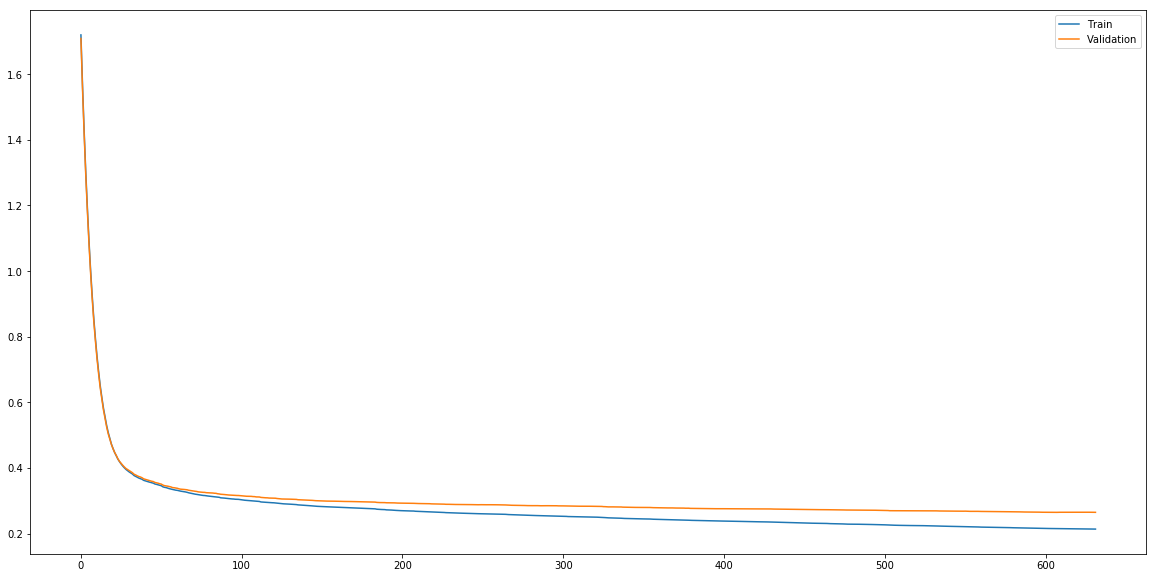

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt

results = model.evals_result()
train_rmse = results['validation_0']['rmse']
val_rmse = results['validation_1']['rmse']
epoch = range(len(train_rmse))
fig = plt.figure(figsize=(20,10))
plt.plot(epoch, train_rmse, label='Train')
plt.plot(epoch, val_rmse, label='Validation')
plt.legend()

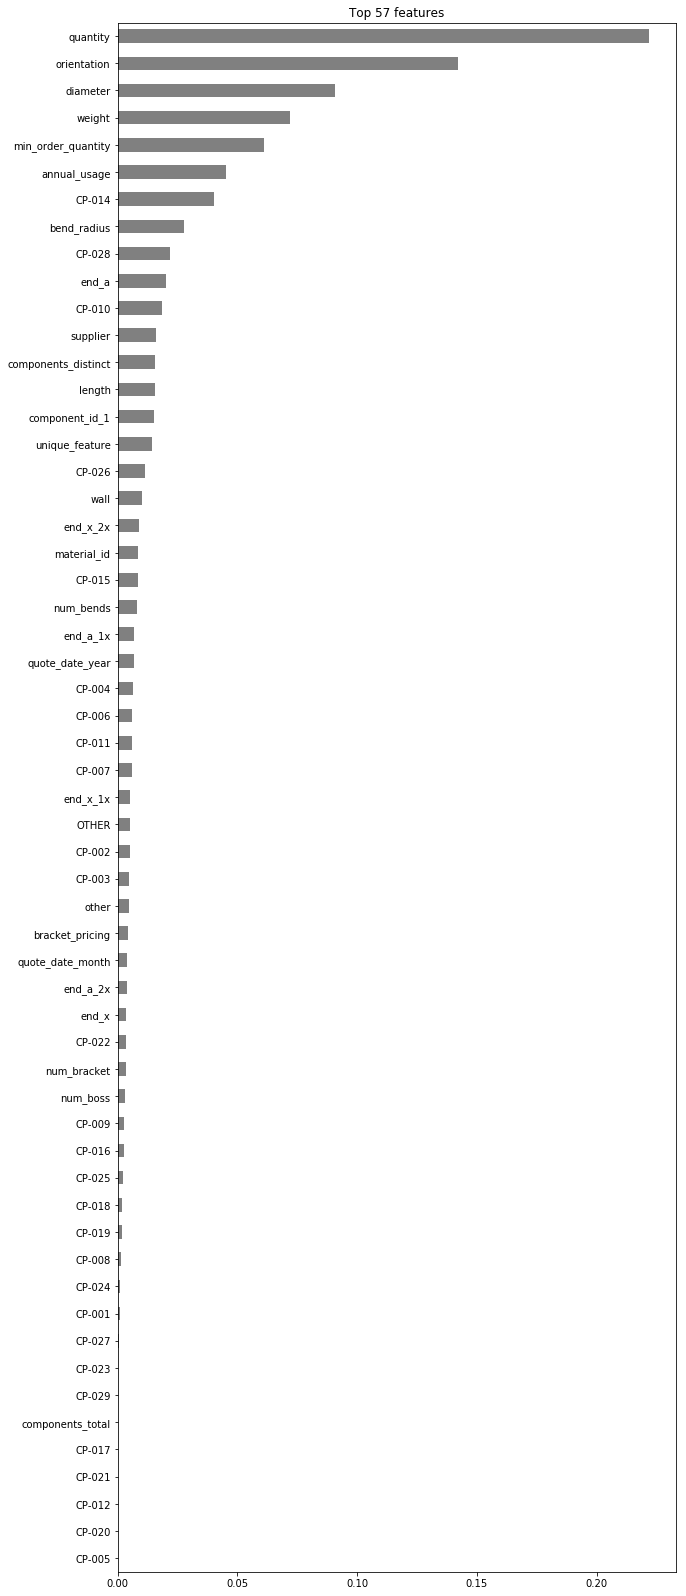

In [40]:
importances = pd.Series(model.feature_importances_, X_train_encoded.columns)

n = len(X_train_encoded.columns)
plt.figure(figsize=(10, n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey')

In [41]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

column = 'annual_usage'

model = XGBRegressor(n_estimators=1000, n_jobs=-1)
model.fit(X_train_encoded.drop(columns=column), y_train_log)
y_pred_log = model.predict(X_val_encoded.drop(columns=column))
score_without = rmse(y_val_log, y_pred_log)
print(f'Validation RMSLE without {column}:', score_without)

model = XGBRegressor(n_estimators=1000, n_jobs=-1)
model.fit(X_train_encoded, y_train_log)
y_pred_log = model.predict(X_val_encoded)
score_with = rmse(y_val_log, y_pred_log)
print(f'Validation RMSLE with {column}:', score_with)

print(f'Drop-Column Importance for {column}:', score_without - score_with)

Validation RMSLE without annual_usage: 0.2935438191215757
Validation RMSLE with annual_usage: 0.25528977749202675
Drop-Column Importance for annual_usage: 0.03825404162954893


In [44]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(model, scoring='neg_mean_squared_error',
                                 cv='prefit', n_iter=2, random_state=42)

permuter.fit(X_val_encoded, y_val_log)
feature_names = X_val_encoded.columns.tolist()
eli5.show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
0.7361 ± 0.0052,quantity
0.2387 ± 0.0026,min_order_quantity
0.0610 ± 0.0021,annual_usage
0.0534 ± 0.0046,supplier
0.0470 ± 0.0004,diameter
0.0386 ± 0.0003,weight
0.0298 ± 0.0016,quote_date_year
0.0196 ± 0.0031,length
0.0112 ± 0.0014,wall
0.0094 ± 0.0010,orientation


In [50]:
print('Shape before removing features:', X_train.shape)

Shape before removing features: (22628, 44)


In [51]:
mask = permuter.feature_importances_ > 0
features = X_train.columns[mask]
X_train = X_train[features]
print('Shape after removing features:', X_train.shape)
X_val = X_val[features]

Shape after removing features: (22628, 44)


In [52]:
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
model = XGBRegressor(n_estimators=2000, n_jobs=-1)
model.fit(X_train_encoded, y_train_log)
y_pred_log = model.predict(X_val_encoded)
print(f'Validation RMSLE', rmse(y_val_log, y_pred_log))

Validation RMSLE 0.24947851933561224


In [53]:
def generate_submission(estimator, X_test, filename):
    y_pred_log = estimator.predict(X_test)
    y_pred = np.expm1(y_pred_log) #Convert to dollars from log-dollars
    submission = pd.read_csv('sample_submission.csv')
    submission['cost'] = y_pred
    submission.to_csv(filename, index=False)

X_test = X_test[features]
X_test_encoded = encoder.transform(X_test)
generate_submission(model, X_test_encoded, 'submission.csv')

In [54]:
!kaggle competitions submit -c caterpillar-tube-pricing -f submission.csv -m "WH first submission"

100%|█████████████████████████████████████████| 450k/450k [00:03<00:00, 130kB/s]
Successfully submitted to Caterpillar Tube Pricing